In [22]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

In [1]:
!git clone https://github.com/congnghia0609/ntc-scv.git

Cloning into 'ntc-scv'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 39 (delta 0), reused 4 (delta 0), pack-reused 35 (from 1)
Receiving objects: 100% (39/39), 186.94 MiB | 15.87 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [2]:
!unzip ./ntc-scv/data/data_test.zip -d ./data
!unzip ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ./ntc-scv

Streaming output truncated to the last 5000 lines.
  inflating: ./data/data_train/train/pos/31228.txt  
  inflating: ./data/data_train/train/pos/3123.txt  
  inflating: ./data/data_train/train/pos/31232.txt  
  inflating: ./data/data_train/train/pos/31233.txt  
  inflating: ./data/data_train/train/pos/31234.txt  
  inflating: ./data/data_train/train/pos/31236.txt  
  inflating: ./data/data_train/train/pos/31238.txt  
  inflating: ./data/data_train/train/pos/31240.txt  
  inflating: ./data/data_train/train/pos/31242.txt  
  inflating: ./data/data_train/train/pos/31247.txt  
  inflating: ./data/data_train/train/pos/31250.txt  
  inflating: ./data/data_train/train/pos/31251.txt  
  inflating: ./data/data_train/train/pos/31252.txt  
  inflating: ./data/data_train/train/pos/31257.txt  
  inflating: ./data/data_train/train/pos/31260.txt  
  inflating: ./data/data_train/train/pos/31261.txt  
  inflating: ./data/data_train/train/pos/31262.txt  
  inflating: ./data/data_train/train/pos/31273.tx

In [3]:
import os
import pandas as pd

def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == "neg":
                label = 0
            if label == "pos":
                label = 1
            data = {
                'sentence': sentence,
                'label': label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [4]:
folder_paths = {
    'train': './data/data_train/train',
    'valid': './data/data_train/test',
    'test': './data/data_test/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

In [5]:
!pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 63.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=86bbc28ad3ccde189fc4f8addcdeccbd4adcde8537735351c220c297502b3233
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [6]:
from langid.langid import LanguageIdentifier, model

def identify_vn(df):
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    not_vi_idx = set()
    THRESHOLD = 0.9
    for idx, row in df.iterrows():
        score = identifier.classify(row["sentence"])
        if score[0] != "vi" or (score[0] == "vi" and score[1] <= THRESHOLD):
            not_vi_idx.add(idx)
    vi_df = df[~df.index.isin(not_vi_idx)]
    not_vi_df = df[df.index.isin(not_vi_idx)]
    return vi_df, not_vi_df

In [7]:
train_df_vi, train_df_other = identify_vn(train_df)

In [8]:
import re
import string

def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # remove HTML Tags: <>
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

In [9]:
train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]
valid_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

<ipython-input-9-e21d2b59a2cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]


In [10]:
train_df_vi

,sentence,label,preprocess_sentence
0,< a class = ' hashtag-link ' href = ' / ho-chi...,0,smoothies fresh ngoài ra thì bình thuong đi đô...
1,Đồ_ăn ở đây ướp thấm vs giá_cả fai chăng thik ...,0,đồ ăn ở đây ướp thấm vs giá cả fai chăng thik ...
2,Chỗ này giờ là cửa_hàng bánh rồi .\n Thay tên ...,0,chỗ này giờ là cửa hàng bánh rồi thay tên đổi ...
3,Khá bất_ngờ là phần nước của quán là của start...,0,khá bất ngờ là phần nước của quán là của start...
4,Thái_độ nhân_viên cực_kì tệ như mình ăn thiếu ...,0,thái độ nhân viên cực kì tệ như mình ăn thiếu ...
...,...,...,...
29995,Mình đến đây được vài lần thấy spa có không_gi...,1,mình đến đây được vài lần thấy spa có không gi...
29996,Xu ́ c xi ́ ch lô ́ c xoa ́ y chiên xu ̀ thơm ...,1,xu ́ c xi ́ ch lô ́ c xoa ́ y chiên xu ̀ thơm ...
29997,"Ở gần quán đã ghé ăn nhiều lần , càng ăn càng ...",1,ở gần quán đã ghé ăn nhiều lần càng ăn càng th...
29998,Bánh bông lan trứng muối rất ngon . Đồ uống vừ...,1,bánh bông lan trứng muối rất ngon đồ uống vừa ...


In [11]:
!pip install torchtext==0.16.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.

In [12]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [13]:
# word-based tokenizer
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [15]:
# build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [16]:
vocabulary["<pad>"]

0

In [17]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    # create iterator for dataset: (sentence, label)
    for index, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

In [23]:
import torch
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    # create inputs, offsets, labels for batch
    encoded_sentences, labels = [], []
    for encoded_sentence, label in batch:
        labels.append(label)
        encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)
        encoded_sentences.append(encoded_sentence)

    labels = torch.tensor(labels, dtype=torch.int64)
    encoded_sentences = pad_sequence(
        encoded_sentences,
        padding_value=vocabulary["<pad>"]
    )

    return encoded_sentences, labels

In [24]:
from torch.utils.data import DataLoader

batch_size = 128
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [25]:
next(iter(train_dataloader))

(tensor([[  7, 190,  48,  ...,   3,   3,   6],
         [ 36,  80,  40,  ..., 128,   5,  60],
         [  2, 127, 142,  ...,  41,  61,   7],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]]),
 tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
         0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
         1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
         0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
         0, 1, 0, 0, 1, 0, 1, 1]))

In [26]:
encoded_sentences, labels = next(iter(train_dataloader))

In [27]:
encoded_sentences.shape

torch.Size([468, 128])

In [34]:
class TextCNN(nn.Module):
    def __init__(
        self,
        vocab_size, embedding_dim, kernel_sizes, num_filters, num_classes):
        super(TextCNN, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.num_classes = num_classes
        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim=self.embedding_dim,
            padding_idx=0
        )
        self.conv = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=k,
                stride=1
            ) for k in kernel_sizes])
        self.fc = nn.Linear(
            len(kernel_sizes) * num_filters,
            num_classes
        )

    def forward(self, x):
      batch_size, sequence_length = x.shape
      x = self.embedding(x.T).transpose(1, 2)
      x = [F.relu(conv(x)) for conv in self.conv]
      x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
      x = torch.cat(x, dim=1)
      x = self.fc(x)
      return x

In [37]:
vocab_size = len(vocabulary)
embedding_dim = 100

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=2
)

In [38]:
vocab_size

10000

In [39]:
predictions = model(encoded_sentences)
predictions

tensor([[-0.5879,  0.7376],
        [-0.4808,  0.4927],
        [-0.7619,  0.8643],
        [-0.5766,  0.4876],
        [-0.5719,  0.6096],
        [-0.4537,  0.2981],
        [-0.7233,  0.4078],
        [-0.2044,  0.3145],
        [-0.3235,  0.5543],
        [-0.5240,  0.6963],
        [-0.5384,  0.2703],
        [-0.8578,  0.5474],
        [-0.4119,  0.4324],
        [-0.2803,  0.3443],
        [-0.4364,  0.4328],
        [-0.4122,  0.6453],
        [-0.5063,  0.5114],
        [-0.2918,  0.7169],
        [-0.2829,  0.5327],
        [-0.4140,  0.4862],
        [-0.3329,  0.4698],
        [-0.5033,  0.4484],
        [-0.2621,  0.6279],
        [-0.4317,  0.3403],
        [-0.3651,  0.3866],
        [-0.0921,  0.4050],
        [-0.3582,  0.4248],
        [-0.3803,  0.4533],
        [-0.2187,  0.5098],
        [-0.1307,  0.7414],
        [-0.4432,  0.0466],
        [-0.7861,  0.4154],
        [-0.4128,  0.4085],
        [-0.4630,  0.4996],
        [-0.4310,  0.5120],
        [-0.2636,  0

In [40]:
predictions.shape

torch.Size([128, 2])

In [41]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [42]:
loss = criterion(predictions, labels)
loss

tensor(0.7765, grad_fn=<NllLossBackward0>)

In [43]:
import time

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero grad
        optimizer.zero_grad()

        # predictions
        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [44]:
model.to(device)

TextCNN(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
)

In [45]:
epoch_acc, epoch_loss = train(model, optimizer, criterion, train_dataloader, device)

| epoch   0 |    50/  233 batches | accuracy    0.729
| epoch   0 |   100/  233 batches | accuracy    0.847
| epoch   0 |   150/  233 batches | accuracy    0.867
| epoch   0 |   200/  233 batches | accuracy    0.873


In [46]:
epoch_acc, epoch_loss

(0.8712574850299402, 0.3833219624512185)

In [47]:
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # predictions
            predictions = model(inputs)

            # compute loss
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [48]:
eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader, device)

In [49]:
eval_acc, eval_loss

(0.8565, 0.3285218118866788)

In [51]:
num_class = 2
vocab_size = len(vocabulary)
embedding_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=2
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        torch.save(model.state_dict(), save_model + '/text_cnn_model.pt')

    # Print loss, acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + '/text_cnn_model.pt'))
    model.eval()

| epoch   1 |    50/  233 batches | accuracy    0.757
| epoch   1 |   100/  233 batches | accuracy    0.848
| epoch   1 |   150/  233 batches | accuracy    0.860
| epoch   1 |   200/  233 batches | accuracy    0.867
-----------------------------------------------------------
| End of epoch   1 | Time:  8.53s | Train Accuracy    0.879 | Train Loss    0.378 | Valid Accuracy    0.877 | Valid Loss    0.311 
-----------------------------------------------------------
| epoch   2 |    50/  233 batches | accuracy    0.921
| epoch   2 |   100/  233 batches | accuracy    0.917
| epoch   2 |   150/  233 batches | accuracy    0.917
| epoch   2 |   200/  233 batches | accuracy    0.910
-----------------------------------------------------------
| End of epoch   2 | Time:  8.45s | Train Accuracy    0.912 | Train Loss    0.228 | Valid Accuracy    0.885 | Valid Loss    0.294 
-----------------------------------------------------------
| epoch   3 |    50/  233 batches | accuracy    0.961
| epoch   3 

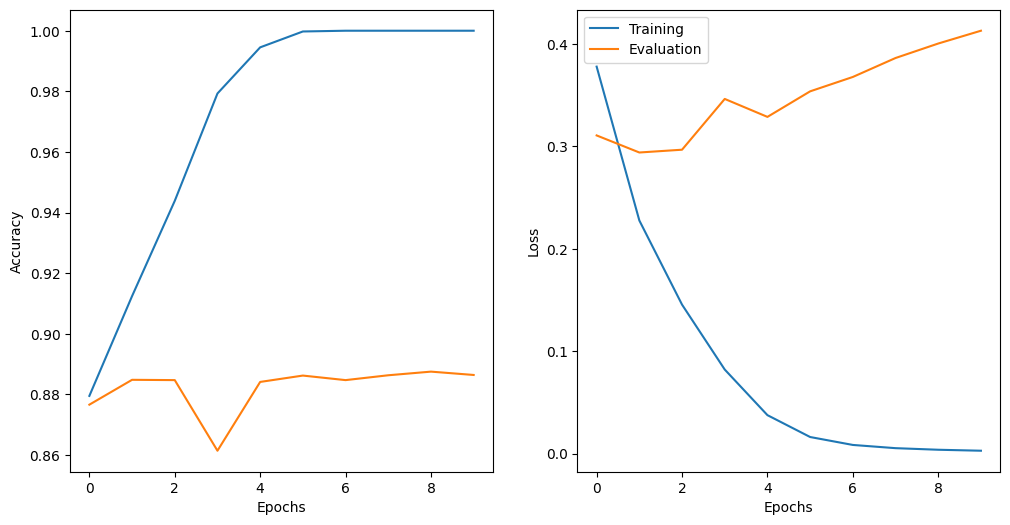

In [52]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)

In [53]:
test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

In [54]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [55]:
test_acc, test_loss = evaluate(model, criterion, valid_dataloader, device)
test_acc, test_loss

(0.8864, 0.41307242242973063)

In [56]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

def load_model(model_path, vocab_size=10000, embedding_dim=100, num_classes=2):
    model = TextCNN(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        kernel_sizes=[3, 4, 5],
        num_filters=100,
        num_classes=num_classes
    )
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    return model

def inference(sentence, vocabulary, model):
    encoded_sentence = vocabulary(tokenizer(sentence))
    encoded_sentence = torch.tensor(encoded_sentence)
    encoded_sentence = torch.unsqueeze(encoded_sentence, 1)

    with torch.no_grad():
        predictions = model(encoded_sentence)
    preds = nn.Softmax(dim=1)(predictions)
    p_max, yhat = torch.max(preds.data, 1)
    return round(p_max.item(), 2)*100, yhat.item()

In [57]:
model = load_model('./model/text_cnn_model.pt')
inference(test_df['preprocess_sentence'][0], vocabulary, model)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


(100.0, 0)

In [58]:
test_df

,sentence,label,preprocess_sentence
0,có thật ko bạn ? ? ? ? vì theo vị_giác của mìn...,0,có thật ko bạn vì theo vị giác của mình thì ch...
1,Chủ quán thân_thiện ... Món cũng lạ hấo dẫn . ...,0,chủ quán thân thiện món cũng lạ hấo dẫn chủ qu...
2,Tôi ko dám tự nhận là dân sành ăn j cả bởi với...,0,tôi ko dám tự nhận là dân sành ăn j cả bởi với...
3,"Quán vỉa_hè ngoài đường khâm thiên . Vắng_vẻ ,...",0,quán vỉa hè ngoài đường khâm thiên vắng vẻ trô...
4,Mình đến đây vì những review tốt cũng_như nghe...,0,mình đến đây vì những review tốt cũng như nghe...
...,...,...,...
9995,"Quán này bán bánh_tráng ngon qtqđ , từ bánh tr...",1,quán này bán bánh tráng ngon qtqđ từ bánh trứn...
9996,"Lẩu mắm bà dú là sự lựa_chọn của mình , ngon q...",1,lẩu mắm bà dú là sự lựa chọn của mình ngon quá xá
9997,"Trùi ui nước mây ở đây đông lắm á , toàn phải ...",1,trùi ui nước mây ở đây đông lắm á toàn phải xế...
9998,Thấy foody đăng_tải nhiều món hot của quán nên...,1,thấy foody đăng tải nhiều món hot của quán nên...
